In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from itertools import product
from collections import Counter, defaultdict

# ringity imports
import ringity as rng
import ringity.utils.plotting as rplotting
import ringity.networks.networkmodel.transformations as rtrafos

from ringity.utils import exceptions as rexceptions

rplotting.set_theme()
DIRNAME_DATA = Path.cwd().parent / 'data'

## Model parameters

In [2]:
N = 2**9

config_dict = {
    'default' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'longerResponse' : {
        'c' : 0.1,
        'r' : 0.375,
        'beta' : 1,
        'rho' : None,
    },
    'weakerInteraction' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorterDelay' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 0.75,
        'rho' : None,
    },
    'constantDensity' : {
        'c' : None,
        'r' : 0.375,
        'beta' : 1,
        'rho' : 0.025,
    },
    'shorterResponse' : {
        'c' : 0.1,
        'r' : 0.125,
        'beta' : 1,
        'rho' : None,
    },
    'evenLongerResponse' : {
        'c' : 0.1,
        'r' : 0.75,
        'beta' : 1,
        'rho' : None,
    },
    'evenShorterDelay' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 0.5,
        'rho' : None,
    },
    'random' : {
        'c' : np.random.uniform(),
        'r' : np.random.uniform(),
        'beta' : np.random.uniform(),
        'rho' : None,
    },
    'random_rho' : {
        'c' : np.random.uniform(),
        'r' : None,
        'beta' : np.random.uniform(),
        'rho' : np.random.uniform(),
    }
}

## Default model

In [3]:
configuration = 'longerResponse'

kwargs = config_dict[configuration]

In [4]:
G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                verbose = True,
                                **kwargs)

Response parameter was set  to: r = 0.375
Rate parameter was set to:   rate = 0.0
Coupling parameter was set to:  c = 0.1
Density parameter was set to: rho = 0.037500000000000006
Uniform (beta = 1) model detected.


In [5]:
rho_obs = nx.density(G)
rho_exp = builder.density
score = rng.ring_score(G)

In [6]:
print(f"rho_obs = {rho_obs:.3f}")
print(f"rho_exp = {rho_exp:.3f}")
print(f"score   = {score:.3f}")

rho_obs = 0.037
rho_exp = 0.038
score   = 0.025


In [7]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

In [8]:
c = builder.coupling
r = builder.response
rho = builder.density
beta = rtrafos.rate_to_beta(builder.rate)

## Interaction function

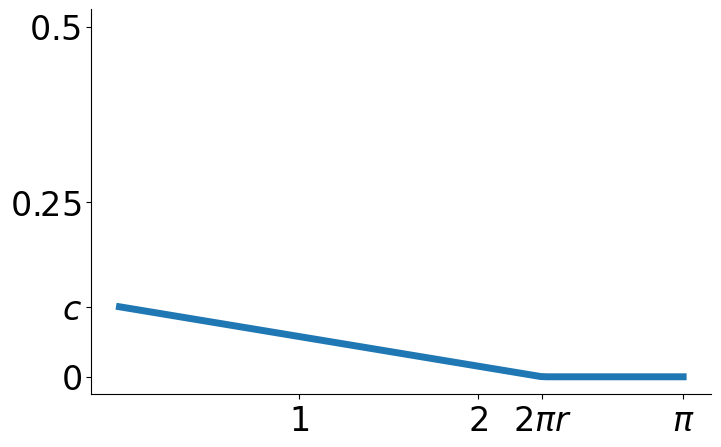

In [9]:
x = np.linspace(0, np.pi, 100)
y = c*(1-x/(2*np.pi*r)).clip(0)

fig_func, ax = plt.subplots(figsize = (8,5))

ax.plot(x, y, linewidth = 5)


plt.xticks([1, 2, 2*np.pi*r, np.pi], [r'$1$', r'$2$', r'$2\pi r$', r'$\pi$'])
plt.yticks([0, 0.25, 0.5, 1, c], [r'$0$', r'$0.25$', r'$0.5$', r'$1$', r'$c$'])

ax.set_ylim(-0.025, max(0.5, c) + 0.025)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# rng.utils.plotting.styling.ax_setup(ax)

## Network visualization

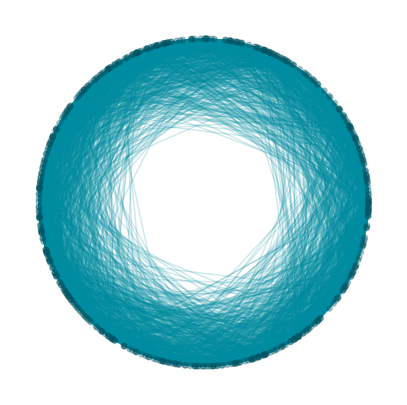

In [10]:
netviz_circ_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = circ_layout)

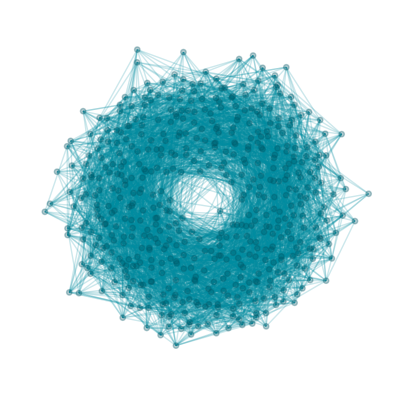

In [11]:
netviz_spri_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = spring_layout)

## ring-score distribution

In [13]:
n_ensemble = 2**4
n_arg_points = 2**6

new_kwargs = {}
for k,v in kwargs.items():
    if kwargs[k] != config_dict['default'][k]:
        arg_name = k
    else:
        new_kwargs[k] = kwargs[k]

arg_list = np.linspace(0, 1, n_arg_points+1)[1:]

In [14]:
N = 2**8

score = defaultdict(list)

total = len(arg_list) * n_ensemble
pbar = tqdm(product(arg_list, range(n_ensemble)), total = total)

for arg, _ in pbar:
    G = rng.network_model(N = N, **new_kwargs, **{arg_name : arg})
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:46<00:00,  9.66it/s]


In [15]:
plot_df = pd.DataFrame(dtype = float)

for r, scores in score.items():
    tmp_df = pd.DataFrame([[r]*len(scores),scores])
    plot_df = pd.concat([plot_df, tmp_df.T], ignore_index = True)
    
plot_df.columns = (arg_name, 'score')

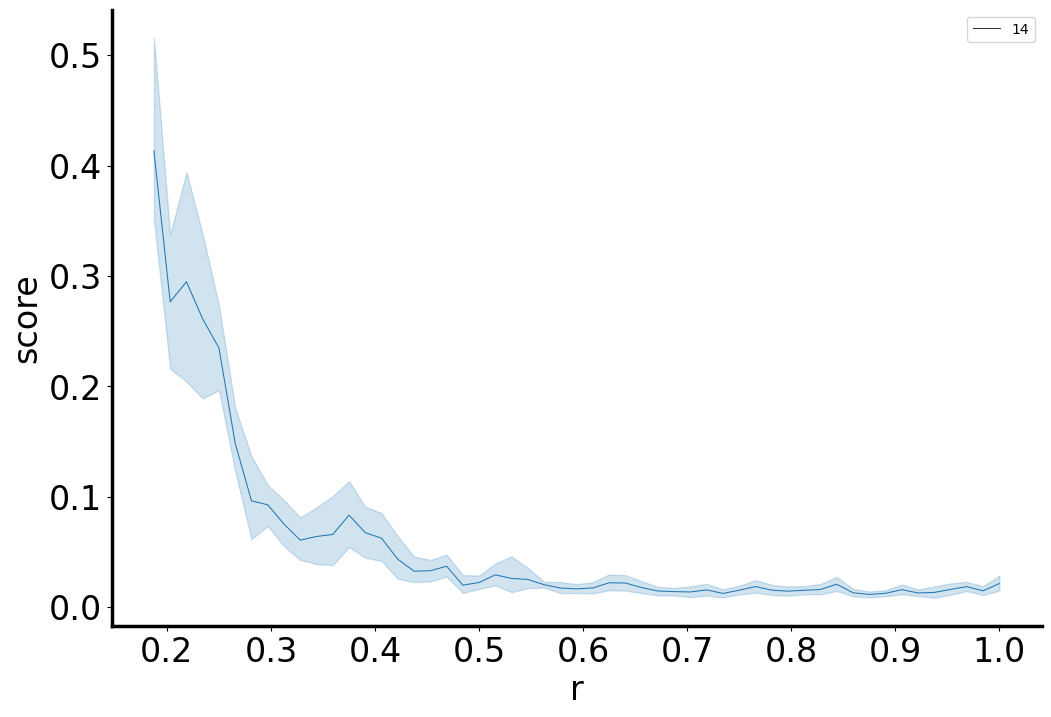

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = arg_name, y = "score", data = plot_df, ax=ax, size=14)
rng.utils.plotting.ax_setup(ax)

plot_df.to_csv(DIRNAME_DATA / 'results' / f"Fig3-scores_{arg_name}-N{N}.csv")
plt.savefig(DIRNAME_DATA / 'plots' / f"Fig3-scores_{arg_name}-N{N}.png")

---

In [33]:
N = builder.N
c = builder.coupling
beta = rate_to_beta(builder.rate)

r_list = np.linspace(0, 1, 11)[1:]

In [34]:
score = defaultdict(list)

t1 = time.time()
for r in r_list:
    print(r)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, r=r, beta=beta, c = builder.coupling)
        score[r].append(rng.ring_score(G))
        
t2 = time.time()
print(20*'-')
print(t2 - t1)

0.1


DisconnectedGraphError: 

AttributeError: module 'ringity' has no attribute 'ax_setup'

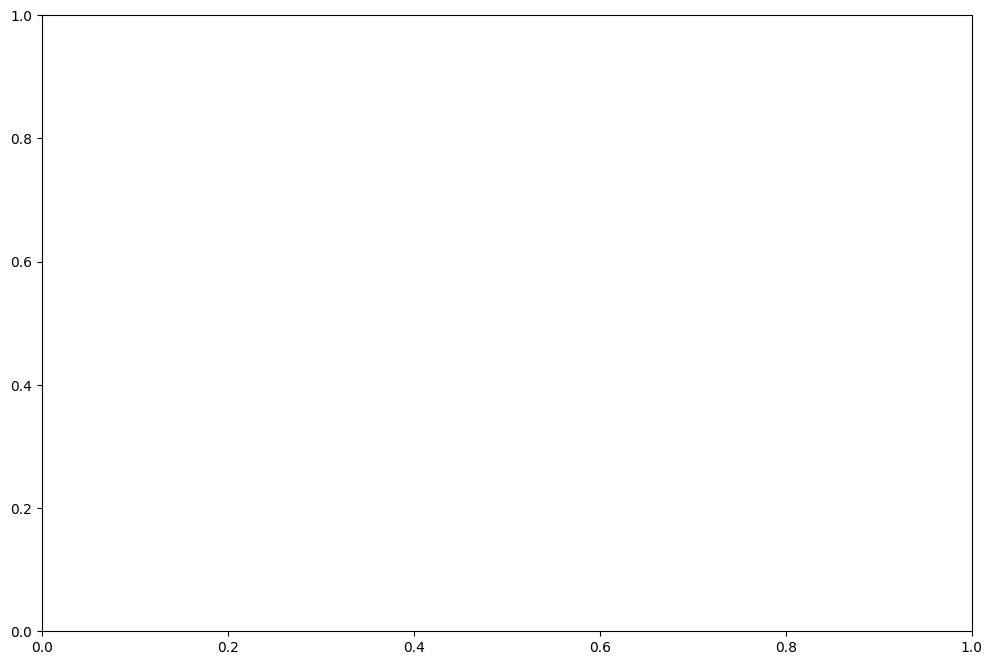

In [35]:
plot_df = pd.melt(pd.DataFrame(score))

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = "variable", y = "value", data = plot_df, ax=ax, size=14)
rng.ax_setup(ax)
plt.savefig("/Users/markusyoussef/Desktop/test.png")

### Variing coupling

In [15]:
new_kwargs = {}

for k,v in kwargs.items():
    if kwargs[k] != config_dict['default'][k]:
        arg_name = k
    else:
        new_kwargs[k] = kwargs[k]

arg_list = np.linspace(0, 1, 11)[1:]

In [ ]:
score = defaultdict(list)

t1 = time.time()
for arg in arg_list:
    print(arg)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, **new_kwargs, **{arg_name : arg})
        score[r].append(rng.ring_score(G))
        
t2 = time.time()
print(20*'-')
print(t2 - t1)

0.1
0.2
0.30000000000000004
0.4


In [ ]:
G = rng.network_model(N=N, verbose = True, **new_kwargs, **{arg_name : arg})

In [27]:
n_ensemble = 2**4
N_list = [2**k for k in range(5, 9)]
r = builder.response
score = defaultdict(list)

t1 = time.time()
for N in N_list:
    print(N)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, c=c, r=r, beta=beta)
        score[N].append(rng.ring_score(G))
        
t2 = time.time()

print(t2 - t1)

19.147202968597412


In [28]:
plot_df = pd.melt(pd.DataFrame(score))

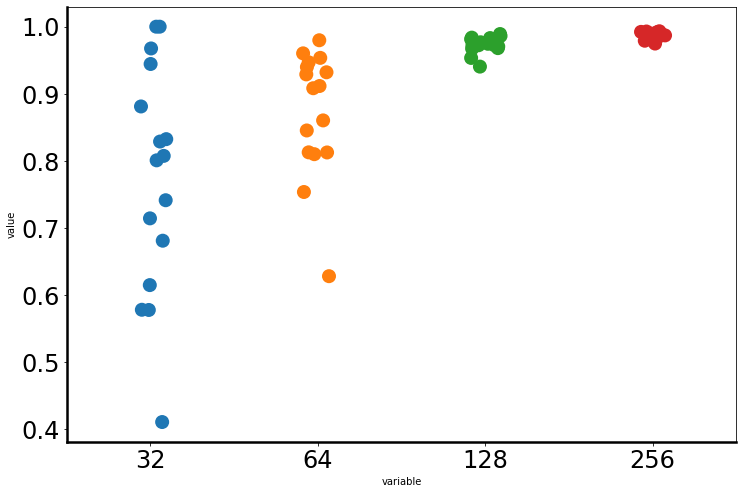

In [29]:
fig, ax = plt.subplots(figsize = (12,8))
sns.stripplot(x = "variable", y = "value", data = plot_df, ax=ax, size=14)
rng.ax_setup(ax)
plt.savefig("/Users/markusyoussef/Desktop/test.png")

## Clustering coefficient

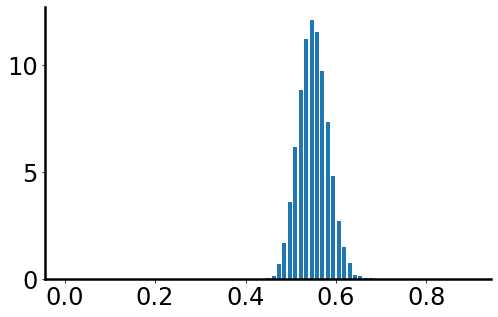

In [32]:
clust = []

for _ in range(2**6):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.clustering_coefficient(G))

clust_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=75, range=(0, 0.9), 
        rwidth = 0.75, density = True);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

## Degree distribution

In [33]:
def expected_conditional_similarity(theta, rate, a):
    if np.isclose(rate, 0, atol=1e-7):
        return a
    
    if np.isclose(rate, np.inf):
        A = 1/(2*np.pi*a)
        B = A*np.pi
        C = B - 1
        return np.clip(np.abs(A*theta - B) - C, 0, 1)
    
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            
            theta_term = -theta*rate * (1 - np.exp(-2*np.pi*rate))
            
            term1  = -2*np.exp(-rate*theta) + 1
            term21 =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate))
            term22 = -np.exp(-2*np.pi*rate)
            
            return norm*(term1 + term21 + term22 + theta_term) + 1
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
        
        def undef_int(t):
            return (np.exp(np.pi*rate)*(np.cosh((np.pi - t)*rate) + (-2*a*np.pi + t)*rate*np.sinh((np.pi - t)*rate)))/(2*a*np.pi*rate**2)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term1 = (-1 + np.cosh((2*np.pi - theta)*rate) + (2*(-1 + a)*np.pi + theta)*rate*np.sinh((2*np.pi - theta)*rate))/(2*a*np.pi*rate**2)
            term2 = undef_int(2*np.pi*a) - undef_int(2*np.pi - theta)
            return norm*term1 + norm*term2
        else:
            return norm*(np.sinh(a*np.pi*rate)**2)/(a*np.pi*rate**2)

In [35]:
c = builder.coupling
r = builder.response
rate = builder.rate

degs_exp = [p for theta in pos for p in np.random.binomial(N-1, c*expected_conditional_similarity(theta=theta, rate=rate, a=r), size=2**10)]

In [36]:
degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

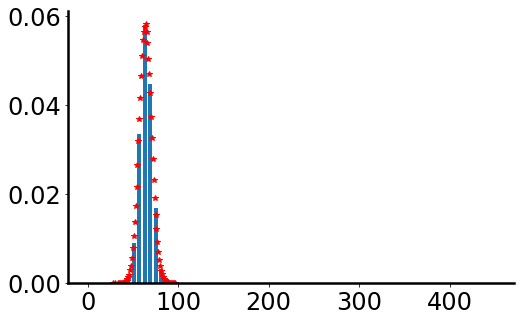

In [37]:
degs = []

for _ in range(2**6):
    G = rng.network_model(N=N, c=c, r=r, beta=beta)
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

deg_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 75, range = (0, 450),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_xlabel('degree', fontsize=24)
#ax.set_ylabel('frequency', fontsize=18)

rng.ax_setup(ax)

## Save data

In [98]:
fig_dir = Path("/Users/markusyoussef/Desktop/fig3/")

fig_func.savefig(fig_dir / f"{configuration}_interactionFunction.png")
fig_func.savefig(fig_dir / f"{configuration}_interactionFunction.pdf")

#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.png")
#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.pdf")

netviz_spri_fig.savefig(fig_dir / f"{configuration}_network_spring.png")
netviz_spri_fig.savefig(fig_dir / f"{configuration}_network_spring.pdf")

clust_fig.savefig(fig_dir / f"{configuration}_clustering.png")
clust_fig.savefig(fig_dir / f"{configuration}_clustering.pdf")

deg_fig.savefig(fig_dir / f"{configuration}_degree.png")
deg_fig.savefig(fig_dir / f"{configuration}_degree.pdf")